In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor
import os
%run diagnostics.ipynb
import numpy as np

In [2]:
import pandas as pd

cols_to_drop = ['timestamp', 'lexeme_id', 'word', 'user_id', 'avg_user_p_recall', 'ui_language', 'learning_language']
current_dir = os.getcwd()
filename = 'df_prepared.csv'
filepath = os.path.normpath(os.path.join(current_dir, '../data/processed/', filename))
chunk_size = 10000
chunks = []

for chunk in pd.read_csv(filepath, chunksize=chunk_size):
    chunk.drop_duplicates(inplace=True)
    chunk.dropna(inplace=True)
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

In [3]:
df.head()

,word_len,tags_list,SUBTLEX,p_recall,delta,history_seen,history_correct,session_seen,session_correct,h_recall,lang_combination,avg_delta,std_delta,avg_h_recall
0,5,"['vblex', 'pri', 'p3', 'sg']",3391.0,1.0,5963,8,6,6,6,0.750000,en-de,3104.416667,2977.078695,0.890225
1,5,"['vblex', 'pri', 'p3', 'sg']",3391.0,0.0,253,14,12,1,0,0.857143,en-de,3104.416667,2977.078695,0.890225
2,5,"['vblex', 'pri', 'p3', 'sg']",3391.0,1.0,65,15,12,1,1,0.800000,en-de,3104.416667,2977.078695,0.890225
3,5,"['vblex', 'pri', 'p3', 'sg']",3391.0,0.5,27,16,13,2,1,0.812500,en-de,3104.416667,2977.078695,0.890225
4,5,"['vblex', 'pri', 'p3', 'sg']",3391.0,1.0,179,15,15,2,2,1.000000,en-de,87253.516209,141166.529740,0.914070


In [4]:
from sklearn.model_selection import train_test_split

train_data_s, test_data_s = train_test_split(df, test_size=0.2)

train_data = train_data_s.drop(columns=['session_seen', 'session_correct'])
test_data = test_data_s.drop(columns=['session_seen', 'session_correct'])

In [5]:
train_data_s.to_csv(os.path.normpath(os.path.join(current_dir, '../data/processed/train_data.csv')))
test_data_s.to_csv(os.path.normpath(os.path.join(current_dir, '../data/processed/test_data.csv')))
                

In [13]:
label = 'p_recall'
presets = 'medium'
excl_model_types=['NeuralNetTorch', 'NeuralNetFastAI', 'KNeighborsDist', 'KNeighborsUnif', 'LightGBM', 'LightGBMXT']
incl_model_types = ['RandomForestMSE', 'XGBoost', 'CatBoost', 'LightGBMLarge']

In [ ]:
predictor = TabularPredictor(label=label).fit(train_data, presets=presets, excluded_model_types = excl_model_types)

No path specified. Models will be saved in: "AutogluonModels/ag-20250318_141114"
Preset alias specified: 'medium' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.3
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.5.0: Wed May  1 20:13:18 PDT 2024; root:xnu-10063.121.3~5/RELEASE_ARM64_T6030
CPU Count:          11
Memory Avail:       11.56 GB / 36.00 GB (32.1%)
Disk Space Avail:   136.90 GB / 460.43 GB (29.7%)
Presets specified: ['medium']
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "/Users/julkakubisa/Documents/PRACA MAGISTERSKA/spaced_repetition_algorithms/notebooks/AutogluonModels/ag-20250318_141114"
Train 

[1000]	valid_set's rmse: 0.262457


In [20]:
# To use previously made predictor
# predictor = TabularPredictor.load("/Users/julkakubisa/Documents/PRACA MAGISTERSKA/spaced_repetition_algorithms/notebooks/AutogluonModels/ag-20250316_132235")

In [36]:
models = predictor.model_names()
models

['KNeighborsUnif',
 'KNeighborsDist',
 'LightGBMXT',
 'LightGBM',
 'RandomForestMSE',
 'CatBoost',
 'NeuralNetFastAI',
 'XGBoost',
 'NeuralNetTorch',
 'LightGBMLarge',
 'WeightedEnsemble_L2']

In [73]:
models[8]

'NeuralNetTorch'

In [84]:
y_pred = predictor.predict(test_data.drop(columns=[label]), model=models[0])
# predictor.predict(test_data, model=models[1])
y_pred = cap_y(y_pred)

y_pred.head()

9412437    0.80000
4596116    1.00000
9589600    1.00000
10562145   1.00000
10008208   1.00000
Name: p_recall, dtype: float32

In [85]:
y_test = test_data['p_recall']
results_df = pd.DataFrame({'y_test':y_test, 'y_pred':y_pred})
results_df.head()

,y_test,y_pred
9412437,0.00000,0.80000
4596116,1.00000,1.00000
9589600,1.00000,1.00000
10562145,1.00000,1.00000
10008208,1.00000,1.00000


In [89]:
print('mae:', (results_df['y_test'] - results_df['y_pred']).abs().mean())

mae: 0.1406804233166956


In [105]:
predictor.evaluate(test_data, silent=True)

{'root_mean_squared_error': -0.24981712541824302,
 'mean_squared_error': -0.06240859615223416,
 'mean_absolute_error': -0.1556838351318015,
 'r2': 0.1427944575282344,
 'pearsonr': 0.4191867835371326,
 'median_absolute_error': -0.09320282936096191}

Text(0.5, 1.0, 'Predicted vs. Actual Recall Probability')

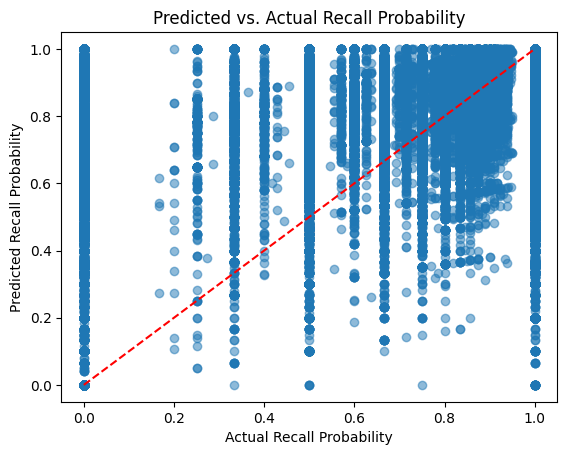

In [106]:
import matplotlib.pyplot as plt

predictions_scatterplot = plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("Actual Recall Probability")
plt.ylabel("Predicted Recall Probability")
plt.title("Predicted vs. Actual Recall Probability")

In [107]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
results_df.describe()

,y_test,y_pred
count,2501031.00000,2501031.00000
mean,0.89743,0.89769
std,0.26982,0.12983
min,0.00000,0.00000
25%,1.00000,0.80000
50%,1.00000,0.95000
75%,1.00000,1.00000
max,1.00000,1.00000


In [28]:
predictor.model_best

'WeightedEnsemble_L2'

In [19]:
results = predictor.fit_summary(show_plot=True)
results["leaderboard"]

OSError: dlopen(/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/lib/lib_lightgbm.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib
  Referenced from: <D3923ACB-D836-32D3-A031-CF91999FDAFC> /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/lib/lib_lightgbm.dylib
  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/local/lib/libomp/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libomp/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/local/lib/libomp/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libomp/libomp.dylib' (no such file)

In [17]:
predictor.leaderboard(test_data)

OSError: dlopen(/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/lib/lib_lightgbm.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib
  Referenced from: <D3923ACB-D836-32D3-A031-CF91999FDAFC> /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/lib/lib_lightgbm.dylib
  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/local/lib/libomp/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libomp/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/local/lib/libomp/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libomp/libomp.dylib' (no such file)

In [ ]:
predictor.feature_importance(test_data)

In [ ]:
print(type(results))